## Variational-based Matrix Product State Compression


Author: Micheal C. Chen

Email: muchuchen03@gmail.com

Matrix product state (MPS) is a compact, structured representation of many-body wave functions. An N-site state $|\psi\rangle$ with local physical dimension $d$ is written as a chain of rank-3 tensors:
$$
|\psi\rangle=\sum_{\{s_i\}} A^{[1]s_1}A^{[2]s_2}\cdots A^{[N]s_N}\,|s_1s_2\ldots s_N\rangle .
$$
Each $A^{[i]s_i}$ carries one physical index $s_i\in\{1,\dots,d\}$ and two bond indices of dimensions $D_{i-1},D_i$. The maximal bond dimension $D=\max_i D_i$ controls the expressive power: larger $D$ can capture more entanglement but increases memory and contraction cost (typically $O(N\,d\,D^3)$ for standard operations).

In practice we often need to **compress** a “large” MPS $|\psi_A\rangle$ (bond $D_s$) into a “smaller” one $|\psi_B\rangle$ (bond $\chi\ll D_s$) while preserving fidelity. This demo implements a **variational compression** procedure: we choose $|\psi_B\rangle$ to minimize the least-squares error
$$
\varepsilon=\bigl\|\,|\psi_A\rangle-|\psi_B\rangle\,\bigr\|^2
=\langle\psi_A|\psi_A\rangle+\langle\psi_B|\psi_B\rangle
-2\,\mathrm{Re}\,\langle\psi_B|\psi_A\rangle .
$$

In [1]:
import numpy as np
import numpy.linalg as LA
from scipy import linalg
import Sub180221 as Sub

For tensor operations, we use `Sub` package provided by Prof. Shuo Yang.

## Distance Calculation
In order to calculate the distance between two MPSs, we define function `CalOverlapMps` to calculate two MPS $|\psi_A\rangle$ and $|\psi_B\rangle$ overlap $\langle \psi_B | \psi_A|\rangle$. And the norm-2 of $|\psi_A\rangle$ and $|\psi_B\rangle$ is:
$$
\varepsilon=\bigl\|\,|\psi_A\rangle-|\psi_B\rangle\,\bigr\|^2
=\langle\psi_A|\psi_A\rangle+\langle\psi_B|\psi_B\rangle
-2\,\mathrm{Re}\,\langle\psi_B|\psi_A\rangle .
$$


In [2]:
def CalOverlapMps(Mps1, Mps2):
    Val = np.array([[1.0 + 0j]])
    Ns = len(Mps1)
    for site in range(Ns):
        Val = Sub.NCon([Val, Mps1[site], np.conj(Mps2[site])], [[1, 2], [1, 3, -1], [2, 3, -2]])
    return np.abs(Val[0][0])

def Norm2Mps(Mps1, Mps2):
    return np.abs(CalOverlapMps(Mps1,Mps1) + CalOverlapMps(Mps2,Mps2) - 2 * np.real(CalOverlapMps(Mps1,Mps2)))

## MPS and Ansatz Initialization
Firstly we prepare a random many-body state in Matrix Product State (MPS) form and immediately place it in a numerically stable **left-canonical** gauge before variational optimization.

For a chain of length $N_s$ and local dimension $d$, each site tensor is drawn as a complex array to avoid accidental degeneracies. The virtual (bond) dimensions are capped to balance expressivity and cost. Near the edges, the exact Schmidt ranks of a generic state grow like powers of $d$, so the left/right bond sizes are limited by those powers and by a global cap. 

Immediately after initialization, the state is brought into a **left-canonical** form by sweeping the orthogonality center from the right boundary to the left. Conceptually, one repeatedly factors each site tensor together with a unitary carried from the right boundary so that the updated site becomes an isometry on its left bond.


In [3]:
def InitMPS(Ns, Dp, Ds):# We randomly initialize a MPS.
    Mps = [None] * Ns
    for site in range(Ns):
        left_bond_dim = min(Dp**site, Dp**(Ns-site), Ds)
        right_bond_dim = min(Dp**(site+1), Dp**(Ns-site-1), Ds)
        Mps[site] = np.random.rand(left_bond_dim, Dp, right_bond_dim) + 1j * np.random.rand(left_bond_dim, Dp, right_bond_dim)

    U = np.eye(np.shape(Mps[-1])[-1])
    for site in range(Ns - 1, -1, -1):
        U, Mps[site] = Sub.Mps_LQP(Mps[site], U)
    return Mps

def InitAnsatz(Ns, Dp, chi): # We build ansatz as a compression of MPS
    Ansatz = [None] * Ns
    for site in range(Ns):
        left_bond_dim = min(Dp**site, Dp**(Ns-site), chi)
        right_bond_dim = min(Dp**(site+1), Dp**(Ns-site-1), chi)
        Ansatz[site] = np.random.rand(left_bond_dim, Dp, right_bond_dim) + 1j * np.random.rand(left_bond_dim, Dp, right_bond_dim)

    U = np.eye(np.shape(Ansatz[-1])[-1])
    for site in range(Ns - 1, -1, -1):
        U, Ansatz[site] = Sub.Mps_LQP(Ansatz[site], U)
    return Ansatz

We immediately initialize corresponding environments. In this case, there are two kinds of environments `NL`, `NR` and `WL`, `WR`. In future sweep, they will be utilized to construct $N_{eff}$ and $W_{eff}$

In [4]:
def InitEnv(Mps, Ansatz):
    Ns = len(Mps)
    # N environment consists of two ansatzs
    NL = [None] * Ns
    NR = [None] * Ns
    NL[0] = np.array([[1.0+0j]])
    NR[-1] = np.array([[1.0+0j]])
    for site in range(Ns - 1, 0, -1):
        NR[site-1] =  Sub.NCon([NR[site], Ansatz[site], np.conj(Ansatz[site])], [[1, 2], [-1, 3, 1], [-2, 3, 2]])
    # W environment consists of original MPS and ansatz
    WL = [None] * Ns
    WR = [None] * Ns
    WL[0] = np.array([[1.0+0j]])
    WR[-1] = np.array([[1.0+0j]])
    for site in range(Ns - 1, 0, -1):
        WR[site-1] = Sub.NCon([WR[site], Mps[site], np.conj(Ansatz[site])], [[1, 2], [-1, 3, 1], [-2, 3, 2]])
        
    return NL, NR, WL, WR

Now we perform sweep back and forth until convergence.

In [5]:
Ns =100
Dp = 2
Ds = 100
chi = 2
Mps = InitMPS(Ns, Dp, Ds)
Ansatz = InitAnsatz(Ns, Dp, chi)
NL, NR, WL, WR = InitEnv(Mps, Ansatz)
err_per_sweep = []
for sweep in range(100):
    
    for site in range(Ns - 1):
        Dl, Dp, Dr = np.shape(Ansatz[site])
        # Build Effective Environment
        Neff  = Sub.NCon([NL[site], np.eye(Dp), NR[site]], [[-1, -4], [-5, -2], [-6, -3]])
        Weff = Sub.NCon([WL[site], Mps[site], WR[site]], [[-1, 1], [1, -2 , 2], [2, -3]])
        Neff = Sub.Group(Neff, [[0, 1, 2], [3, 4, 5]])
        Weff = Sub.Group(Weff, [[0, 1, 2]])
        # Solve the tensor is equivalent to solve Ax = b
        T_vec = np.reshape(LA.solve(Neff, Weff), (Dl, Dp, Dr))
        Ansatz[site], U = Sub.Mps_QR0P(T_vec)
        # Update each environment
        NL[site+1] = Sub.NCon([NL[site], np.conj(Ansatz[site]), Ansatz[site]], [[1, 2], [1, 3, -1], [2, 3, -2]])
        WL[site+1] = Sub.NCon([WL[site], np.conj(Ansatz[site]), Mps[site]], [[1, 2], [1, 3, -1], [2, 3, -2]])
        # Update each tensor
        Ansatz[site+1] = np.tensordot(U, Ansatz[site+1], (1, 0))
        
    for site in range(Ns-1, 0, -1):
        Dl, Dp, Dr = np.shape(Ansatz[site])
        Neff  = Sub.NCon([NL[site], np.eye(Dp), NR[site]], [[-1, -4], [-5, -2], [-6, -3]])
        Weff = Sub.NCon([WL[site], Mps[site], WR[site]], [[-1, 1], [1, -2 , 2], [2, -3]])
        Neff = Sub.Group(Neff, [[0, 1, 2], [3, 4, 5]])
        Weff = Sub.Group(Weff, [[0, 1, 2]])
    
        T_vec = np.reshape(LA.solve(Neff, Weff), (Dl, Dp, Dr))
        U, Ansatz[site] = Sub.Mps_LQ0P(T_vec)
        
        NR[site-1] = Sub.NCon([NR[site], Ansatz[site], np.conj(Ansatz[site])], [[1, 2], [-1, 3, 1], [-2, 3, 2]])
        WR[site-1] = Sub.NCon([WR[site], Mps[site], np.conj(Ansatz[site])], [[1, 2], [-1, 3, 1], [-2, 3, 2]])

        Ansatz[site-1] = np.tensordot(Ansatz[site-1], U, (2, 0))
        
    err_per_sweep.append(Norm2Mps(Mps, Ansatz))
    print(f"Sweep {sweep:3d}  ||MPS-Ansatz||^2 = {err_per_sweep[-1]:.6e}")

Sweep   0  ||MPS-Ansatz||^2 = 4.508211e-07
Sweep   1  ||MPS-Ansatz||^2 = 4.493419e-07
Sweep   2  ||MPS-Ansatz||^2 = 4.493419e-07
Sweep   3  ||MPS-Ansatz||^2 = 4.493419e-07
Sweep   4  ||MPS-Ansatz||^2 = 4.493419e-07
Sweep   5  ||MPS-Ansatz||^2 = 4.493419e-07
Sweep   6  ||MPS-Ansatz||^2 = 4.493419e-07
Sweep   7  ||MPS-Ansatz||^2 = 4.493419e-07
Sweep   8  ||MPS-Ansatz||^2 = 4.493419e-07
Sweep   9  ||MPS-Ansatz||^2 = 4.493419e-07
Sweep  10  ||MPS-Ansatz||^2 = 4.493419e-07
Sweep  11  ||MPS-Ansatz||^2 = 4.493419e-07
Sweep  12  ||MPS-Ansatz||^2 = 4.493419e-07
Sweep  13  ||MPS-Ansatz||^2 = 4.493419e-07
Sweep  14  ||MPS-Ansatz||^2 = 4.493419e-07
Sweep  15  ||MPS-Ansatz||^2 = 4.493419e-07
Sweep  16  ||MPS-Ansatz||^2 = 4.493419e-07
Sweep  17  ||MPS-Ansatz||^2 = 4.493419e-07
Sweep  18  ||MPS-Ansatz||^2 = 4.493419e-07
Sweep  19  ||MPS-Ansatz||^2 = 4.493419e-07
Sweep  20  ||MPS-Ansatz||^2 = 4.493419e-07
Sweep  21  ||MPS-Ansatz||^2 = 4.493419e-07
Sweep  22  ||MPS-Ansatz||^2 = 4.493419e-07
Sweep  23  

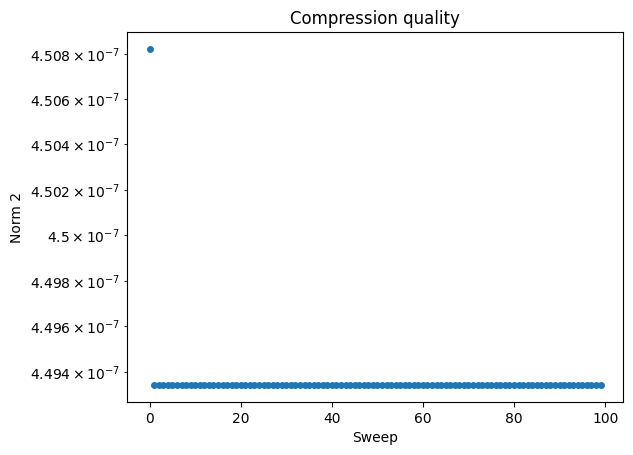

In [6]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(range(len(err_per_sweep)), err_per_sweep, s=16)
plt.yscale('log')
plt.xlabel('Sweep')
plt.ylabel('Norm 2')
plt.title('Compression quality')
plt.show()